In [14]:
getwd()
setwd("/sharedFolder/Paper_clusters_from_scratch/")
getwd()

[1] "/sharedFolder/Paper_clusters_from_scratch"

[1] "/sharedFolder/Paper_clusters_from_scratch"

In [99]:
# LOAD LIBRARIES
library(Seurat)
library(tidyverse)
library(future)
library(ggplot2)
library(dplyr)
library(presto)
library(enrichR)
library(cowplot)

In [72]:
# SET UP NAMES
timepoints <- c("23days","1month","1.5month","2month","3month","4month","5month","6month")
housekeeping_genes <- c("ACTB","DLG4")
genes_of_interest <- c("SRCIN1","KIAA1217","CIT")
path_to_data <- "/sharedFolder/Data/"

# sc_data <- ""

name_new_dir_0 <- paste(getwd(),"/Results",sep="")
if (!dir.exists(name_new_dir_0)) {
  dir.create(name_new_dir_0)
} 

In [24]:
i <- 1
print(timepoints[i])

[1] "23days"


In [26]:
# LOAD DATA AND CREATE&NORMALIZE SEURAT OBJECT

# Load
sc_data <- Read10X(data.dir = paste(path_to_data, "expression_", timepoints[i], sep=""), gene.column = 1) 
    
# Create Seurat object
sc_data <- CreateSeuratObject(counts = sc_data, min.cells = 3, min.features = 500, project = timepoints[i], names.delim = "-", names.field = 2)
    
# Normalize the data
sc_data <- NormalizeData(sc_data, normalization.method = "LogNormalize", scale.factor = 1e6)
    
# Identify variable features
sc_data <- FindVariableFeatures(sc_data, selection.method = "mvp", nfeatures = 2000)

# Scale data 
sc_data <- ScaleData(sc_data)

Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29736
Number of edges: 1146654

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9174
Number of communities: 20
Elapsed time: 18 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7386 2260 2122 2025 2019 1788 1753 1722 1667 1570 1446 1021  869  537  481  400 
  16   17   18   19 
 363  116  106   85 


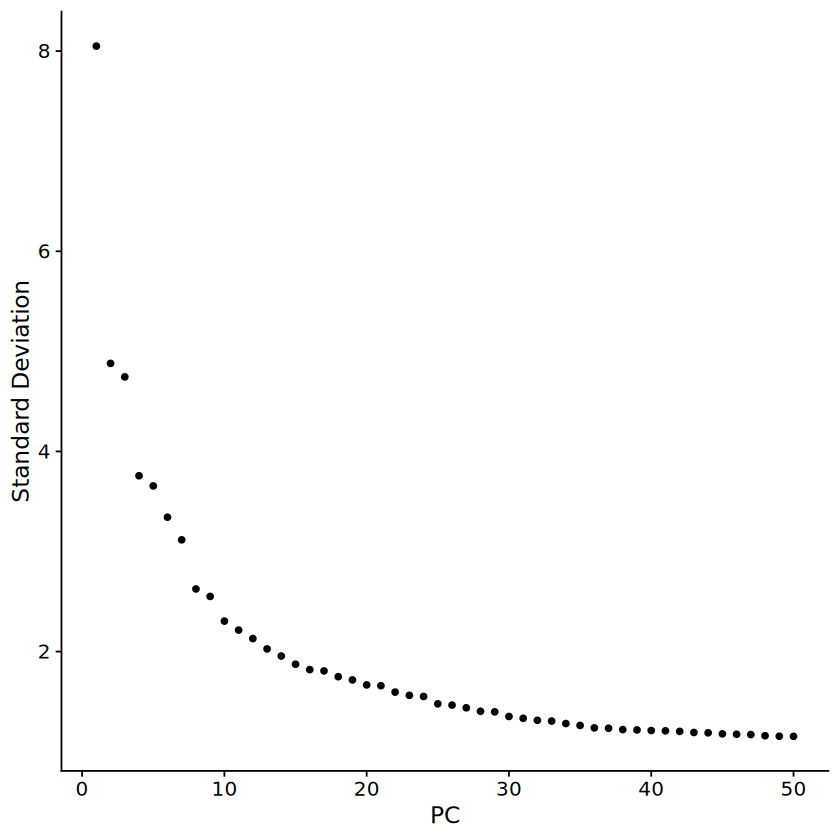

In [27]:
# PCA&Clusterization 

# PCA
sc_data <- RunPCA(sc_data, npcs = 50, verbose = FALSE)
print(ElbowPlot(object = sc_data, ndims = 50))
    
# Cluster the cells
sc_data <- FindNeighbors(sc_data, dims = 1:40)
sc_data <- FindClusters(sc_data, resolution = 0.6)

print(table(Idents(sc_data)))

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:55:46 UMAP embedding parameters a = 0.9922 b = 1.112

12:55:46 Read 29736 rows and found 40 numeric columns

12:55:46 Using Annoy for neighbor search, n_neighbors = 30

12:55:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:55:52 Writing NN index file to temp file /tmp/RtmpNww7uo/filec665a335909

12:55:52 Searching Annoy index using 1 thread, search_k = 3000

12:56:08 Annoy recall = 100%

12:56:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

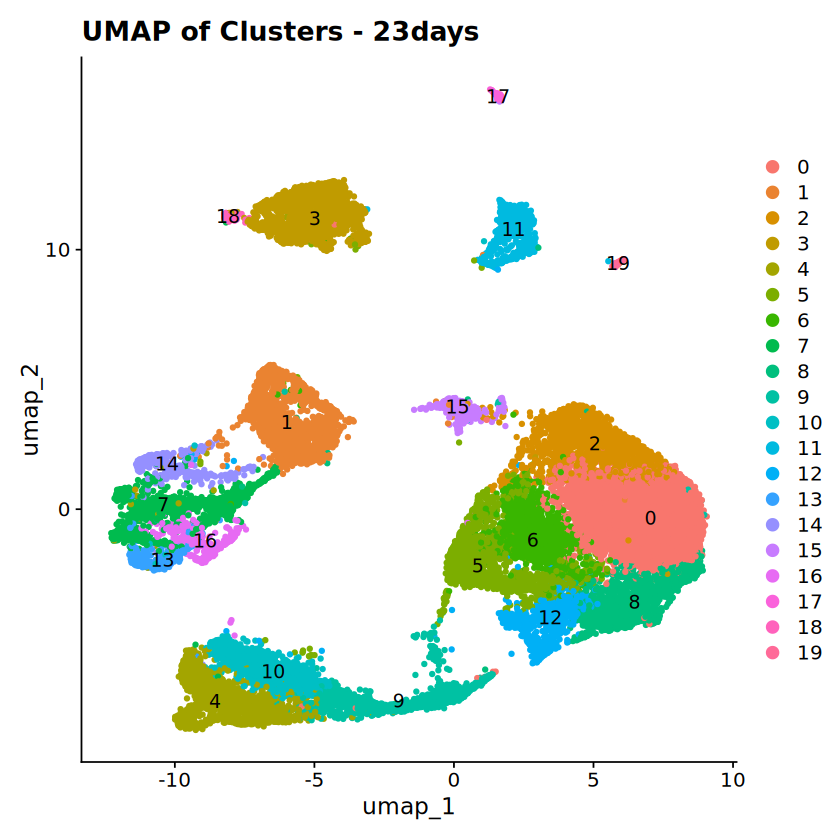

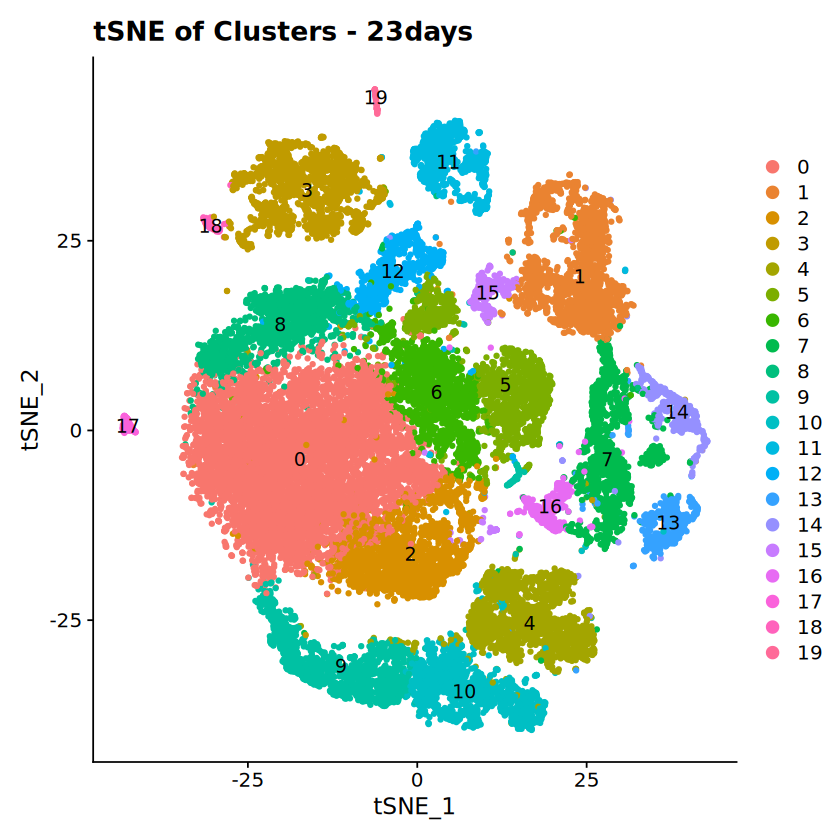

In [28]:
# UMAP & tSNE

sc_data_UMAP <- RunUMAP(sc_data, dims = 1:40)
sc_data_tSNE <- RunTSNE(sc_data, dims = 1:40)

plot_UMAP <- DimPlot(sc_data_UMAP, reduction = "umap", label = TRUE, pt.size = 1) + ggtitle(paste("UMAP of Clusters -",timepoints[i]))
plot_tSNE <- DimPlot(sc_data_tSNE, reduction = "tsne", label = TRUE, pt.size = 1) + ggtitle(paste("tSNE of Clusters -",timepoints[i]))
plot_UMAP
plot_tSNE

# CombinePlots(plot=list(plot_UMAP,plot_tSNE), ncol=2)

In [30]:
# FIND ALL MARKERS

cluster_markers <- FindAllMarkers(sc_data,
                                  only.pos = TRUE,   # Considera solo i marker espressi positivamente
                                  min.pct = 0.25,    # Percentuale minima di espressione nelle cellule del cluster
                                  logfc.threshold = 0.25)  # Soglia minima di LogFC

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19



In [74]:
expression_goi <- FetchData(sc_data, vars = genes_of_interest)
expression_hk <- FetchData(sc_data, vars = housekeeping_genes)

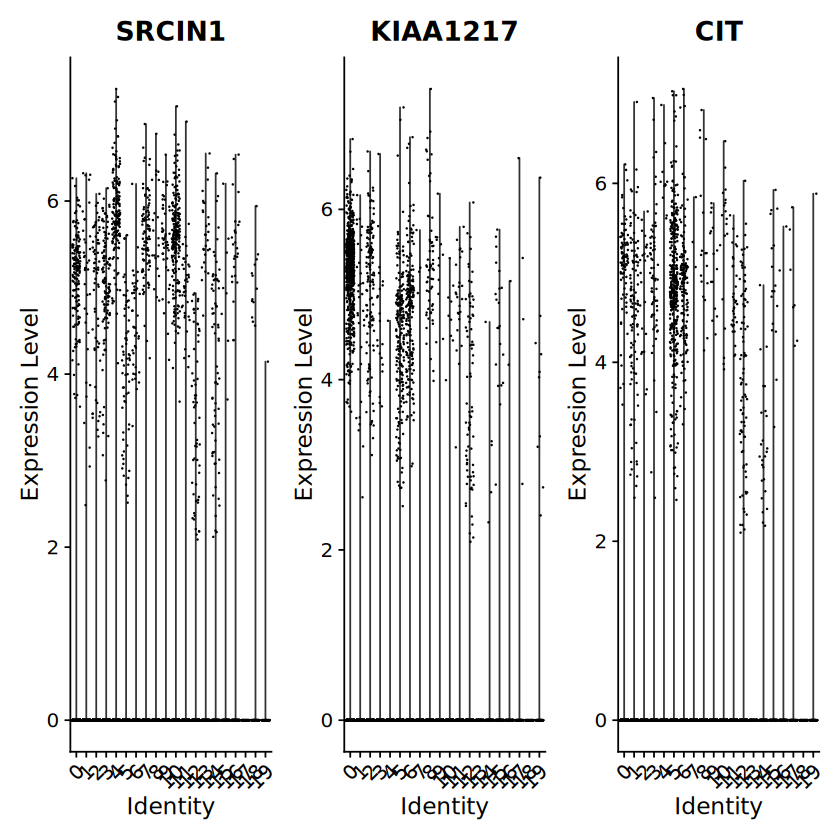

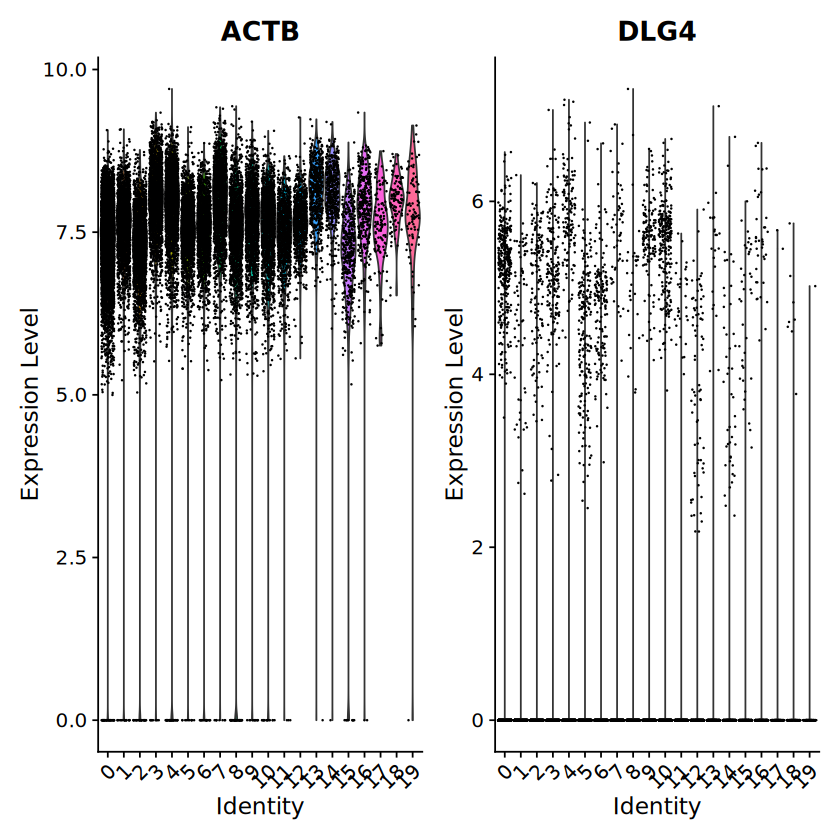

In [49]:
VlnPlot(sc_data, features = genes_of_interest, group.by = "seurat_clusters")
VlnPlot(sc_data, features = housekeeping_genes, group.by = "seurat_clusters")

[[1]]
                           Df Sum Sq Mean Sq F value Pr(>F)    
sc_data$seurat_clusters    19   1053   55.43    51.4 <2e-16 ***
Residuals               29716  32047    1.08                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[[2]]
                           Df Sum Sq Mean Sq F value Pr(>F)    
sc_data$seurat_clusters    19   1170   61.57   55.12 <2e-16 ***
Residuals               29716  33190    1.12                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[[3]]
                           Df Sum Sq Mean Sq F value Pr(>F)    
sc_data$seurat_clusters    19   1852   97.49   131.5 <2e-16 ***
Residuals               29716  22024    0.74                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


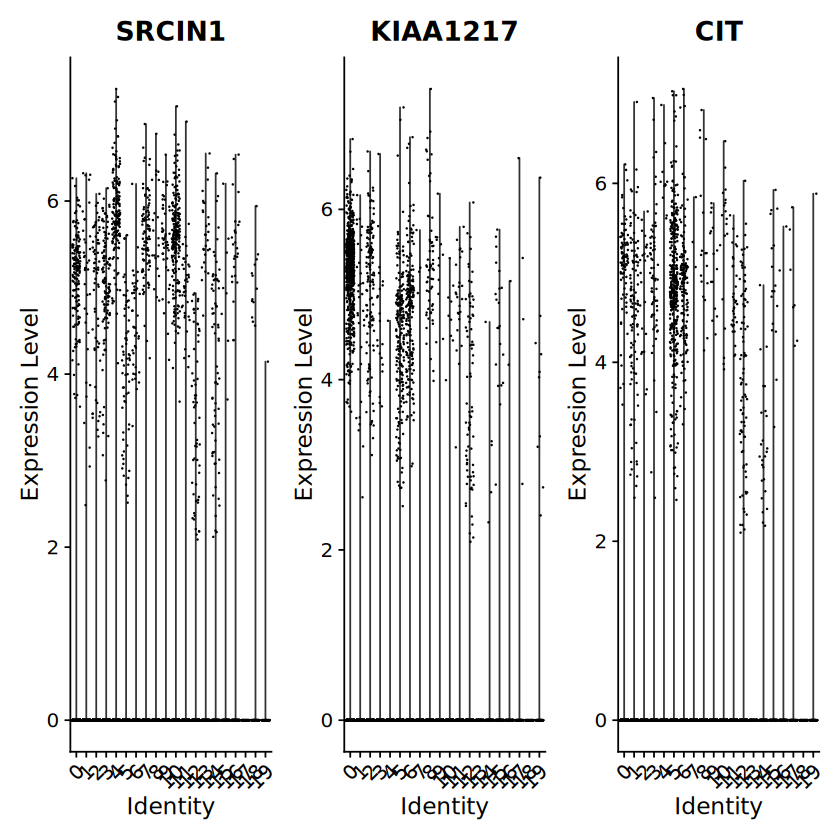

In [50]:
anova_results <- lapply(genes_of_interest, function(gene) {
  # Perform ANOVA
  aov_result <- aov(expression_goi[[gene]] ~ sc_data$seurat_clusters)
  summary(aov_result)
})

# View the results
anova_results


# Fetch normalized data
expression_goi_norm <- FetchData(sc_data, vars = genes_of_interest, layer = "data")

# Plot with normalized data
VlnPlot(sc_data, features = genes_of_interest, group.by = "seurat_clusters", layer = "data")

Warning message:
“Removed 284 rows containing non-finite outside the scale range (`stat_bin()`).”


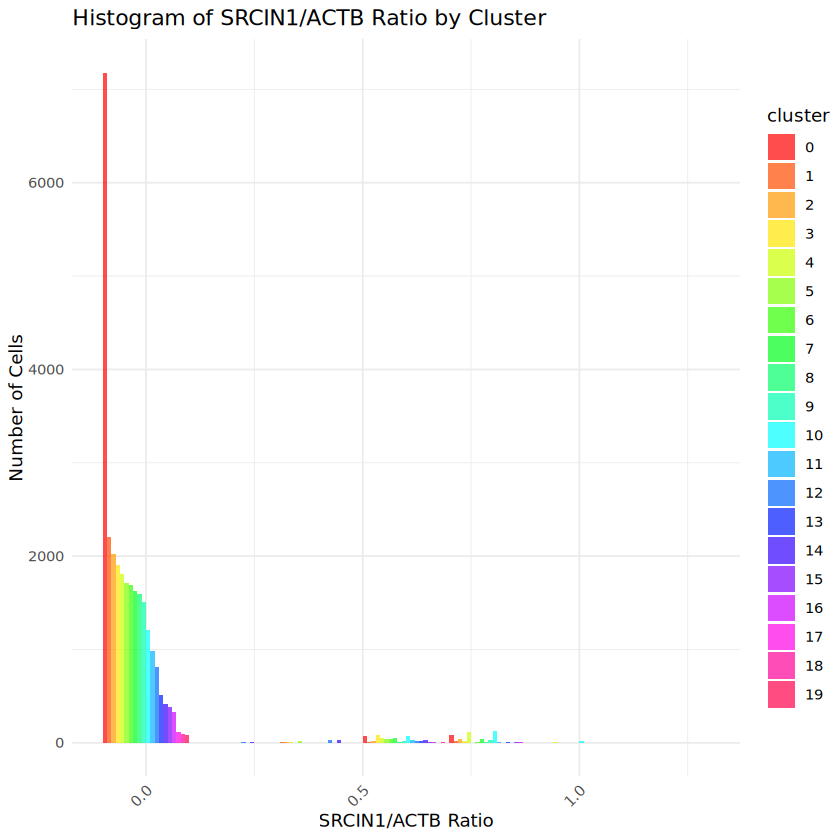

In [78]:
# Plot a histogram of the SRCIN1/ACTB ratio for each cluster
ggplot(expression_data, aes(x = ratio, fill = cluster)) +
  geom_histogram(binwidth = 0.2, position = "dodge", alpha = 0.7) +
  labs(title = "Histogram of SRCIN1/ACTB Ratio by Cluster",
       x = "SRCIN1/ACTB Ratio",
       y = "Number of Cells") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = rainbow(length(unique(expression_data$cluster)))) 

In [59]:
summary(expression_goi)
summary(expression_hk)

     SRCIN1          KIAA1217           CIT        
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :0.0000   Median :0.0000  
 Mean   :0.2188   Mean   :0.2387   Mean   :0.1698  
 3rd Qu.:0.0000   3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :7.2956   Max.   :7.4142   Max.   :7.0554  

      ACTB            DLG4       
 Min.   :0.000   Min.   :0.0000  
 1st Qu.:7.230   1st Qu.:0.0000  
 Median :7.608   Median :0.0000  
 Mean   :7.511   Mean   :0.3309  
 3rd Qu.:7.962   3rd Qu.:0.0000  
 Max.   :9.701   Max.   :7.3000  

Warning message:
“Removed 284 rows containing non-finite outside the scale range (`stat_bin()`).”


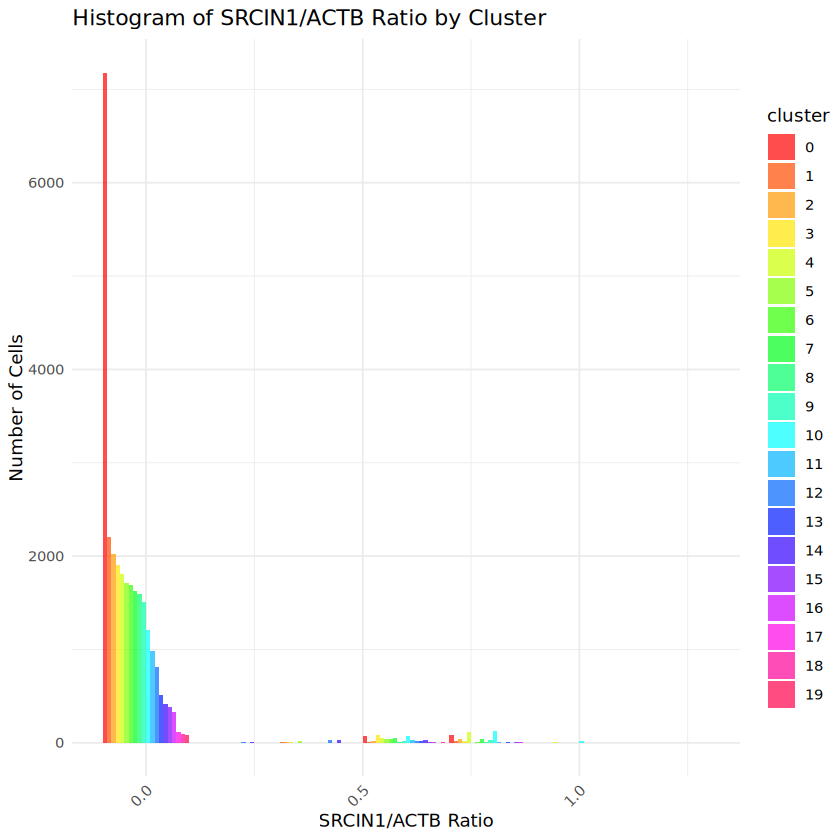

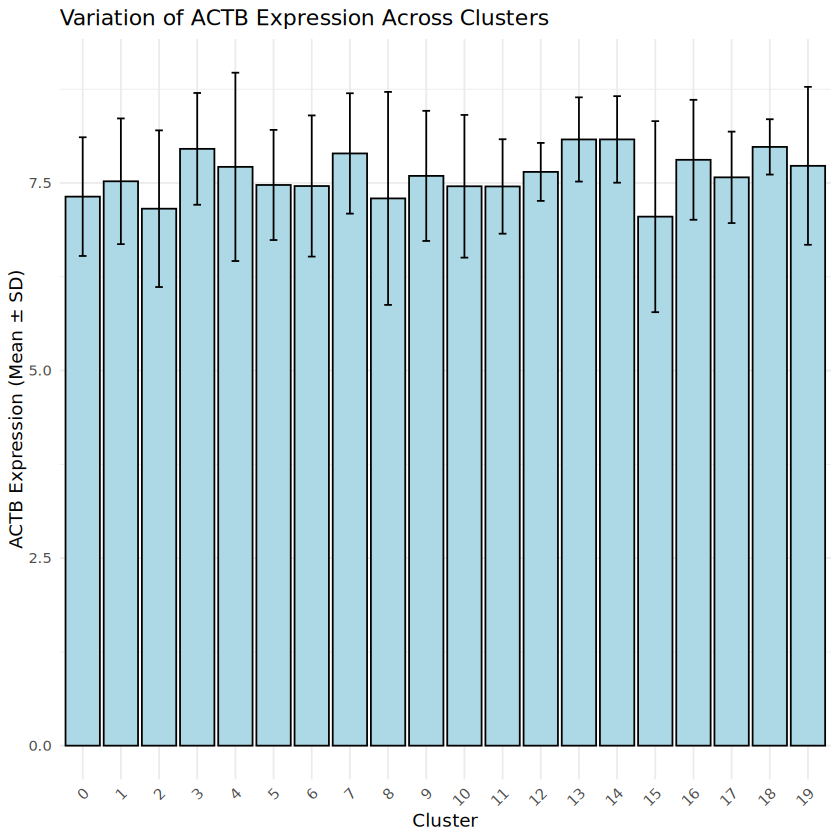

In [82]:
# Calculate the ratio of SRCIN1 to ACTB for each cell
expression_data[1] <- expression_goi[1]
expression_data[2] <- expression_hk[1]

expression_data$ratio <- (expression_data$SRCIN1 / expression_data$ACTB)

# Add the cluster information to the data
expression_data$cluster <- sc_data$seurat_clusters[colnames(sc_data)]

# Now, we have a data frame where each cell has the SRCIN1/ACTB ratio and its associated cluster



library(ggplot2)

# Plot a histogram of the SRCIN1/ACTB ratio for each cluster
ggplot(expression_data, aes(x = ratio, fill = cluster)) +
  geom_histogram(binwidth = 0.2, position = "dodge", alpha = 0.7) +
  labs(title = "Histogram of SRCIN1/ACTB Ratio by Cluster",
       x = "SRCIN1/ACTB Ratio",
       y = "Number of Cells") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = rainbow(length(unique(expression_data$cluster)))) 


# Calculate the mean and standard deviation of ACTB expression for each cluster
ACTB_stats <- aggregate(ACTB ~ cluster, data = expression_data, FUN = function(x) c(mean = mean(x), sd = sd(x)))

# Flatten the data for better visualization
ACTB_stats <- do.call(data.frame, ACTB_stats)

# Plot the mean and SD of ACTB expression across clusters
ggplot(ACTB_stats, aes(x = cluster, y = ACTB.mean)) +
  geom_bar(stat = "identity", fill = "lightblue", color = "black") +
  geom_errorbar(aes(ymin = ACTB.mean - ACTB.sd, ymax = ACTB.mean + ACTB.sd), width = 0.2) +
  labs(title = "Variation of ACTB Expression Across Clusters",
       x = "Cluster",
       y = "ACTB Expression (Mean ± SD)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 37 rows containing missing values or values outside the scale range (`geom_bar()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 39 rows containing missing values or values outside the scale range (`geom_bar()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 36 rows containing missing values or values outside the scale range (`geom_bar()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 34 rows containing missing values or values outside the scale range (`geom_bar()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 46 rows containing missing values or values outside the scale range (`geom_bar()`).”
Warni

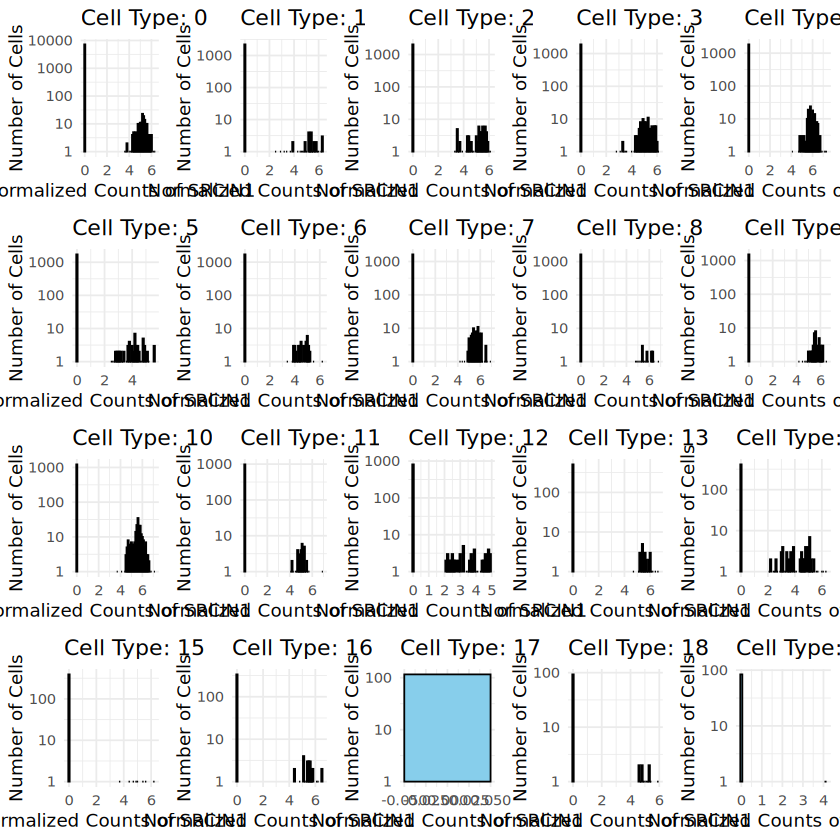

In [98]:
# Extract the normalized counts for the gene
gene_counts <- FetchData(sc_data, vars = "SRCIN1")[, 1]  # Use [,1] to extract as a vector

# Get the cell type information (assuming it's stored in "seurat_clusters" or another metadata column)
clusters <- sc_data$seurat_clusters  # Or replace with your metadata column for cell types

# Create an empty list to store plots
plot_list <- list()

# Sort the unique cell types alphabetically
sorted_clusters <- sort(unique(clusters))

# For each sorted cell type, create a histogram of normalized counts for the gene
for (cluster in sorted_clusters) {
  # Subset the data by cell type
  cells_in_type <- which(clusters == cluster)
  gene_counts_type <- gene_counts[cells_in_type]
  
  # Create the plot for this cell type
  p <- ggplot(data.frame(counts = gene_counts_type), aes(x = counts)) +
    geom_histogram(binwidth = 0.1, fill = "skyblue", color = "black") +
    labs(title = paste("Cell Type:", cluster), x = paste("Normalized Counts of", "SRCIN1"), y = "Number of Cells") +
    theme_minimal() +
    scale_y_log10() # Apply log scale for y-axis
  
  # Append the plot to the list
  plot_list[[cluster]] <- p
}
#plot_list

# Combine all plots into a single image
combined_plot <- plot_grid(plotlist = plot_list, ncol = 5) +  # You can adjust ncol for more columns
theme(panel.background = element_rect(fill = 'white', colour = 'white'))
print(combined_plot)

# Save the plot
ggsave("gene_distribution_by_cluster.png", combined_plot, width = 12, height = 10)
